# Setup

In [1]:
from google.colab import drive
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def calculate_daily_long_trade_return_percentage(predicted_prices, true_prices):
  def generate_daily_trade_signals_long_only(predicted_prices, true_prices):
    signals = torch.zeros_like(predicted_prices)
    signals[:-1] = torch.where(predicted_prices[1:] > predicted_prices[:-1], 1, 0)  # Buy if tomorrow's predicted price > today's
    return signals

  signals = generate_daily_trade_signals_long_only(predicted_prices, true_prices)

  # Calculate price differences and percentage change
  price_diff = true_prices[1:] - true_prices[:-1]
  percentage_returns = (price_diff / true_prices[:-1])  # Convert to percentage change
  # Calculate returns based on signals
  returns = signals[:-1] * percentage_returns

  # Step 1: Calculate cumulative returns
  cumulative_returns = torch.cumprod(1 + returns, dim=0)

  # Step 2: Calculate running maximum of cumulative returns
  running_max, _ = torch.cummax(cumulative_returns, dim=0)

  # Step 3: Calculate drawdowns
  drawdowns = (cumulative_returns - running_max) / running_max

  # Step 4: Find the maximum drawdown
  max_drawdown = drawdowns.min()

  print("Return:", cumulative_returns[-1].item() - 1)
  print("Max Drawdown:", max_drawdown.item())
  return cumulative_returns[-1].item() - 1, max_drawdown.item()

In [4]:
def calculate_daily_short_trade_return_percentage(predicted_prices, true_prices):
  def generate_daily_trade_signals_short_only(predicted_prices, true_prices):
    signals = torch.zeros_like(predicted_prices)
    # Generate a short signal (-1) if tomorrow's predicted price is lower than today's predicted price
    signals[:-1] = torch.where(predicted_prices[1:] < predicted_prices[:-1], 1, 0)
    return signals

  signals = generate_daily_trade_signals_short_only(predicted_prices, true_prices)

  # Calculate price differences and percentage change
  price_diff = true_prices[:-1] - true_prices[1:]  # Since this is a short trade, we reverse the diff
  percentage_returns = (price_diff / true_prices[:-1])  # Convert to percentage change
  # Calculate returns based on signals
  returns = signals[:-1] * percentage_returns
  # Step 1: Calculate cumulative returns
  cumulative_returns = torch.cumprod(1 + returns, dim=0)

  # Step 2: Calculate running maximum of cumulative returns
  running_max, _ = torch.cummax(cumulative_returns, dim=0)

  # Step 3: Calculate drawdowns
  drawdowns = (cumulative_returns - running_max) / running_max

  # Step 4: Find the maximum drawdown
  max_drawdown = drawdowns.min()

  print("Return:", cumulative_returns[-1].item() - 1)
  print("Max Drawdown:", max_drawdown.item())

# Data Pipeline


In [5]:
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:

file_path = "/content/drive/MyDrive/24fall_dlProject/BTC-USD_stock_data.csv"

data = pd.read_csv(file_path,index_col='Date',parse_dates=['Date'])

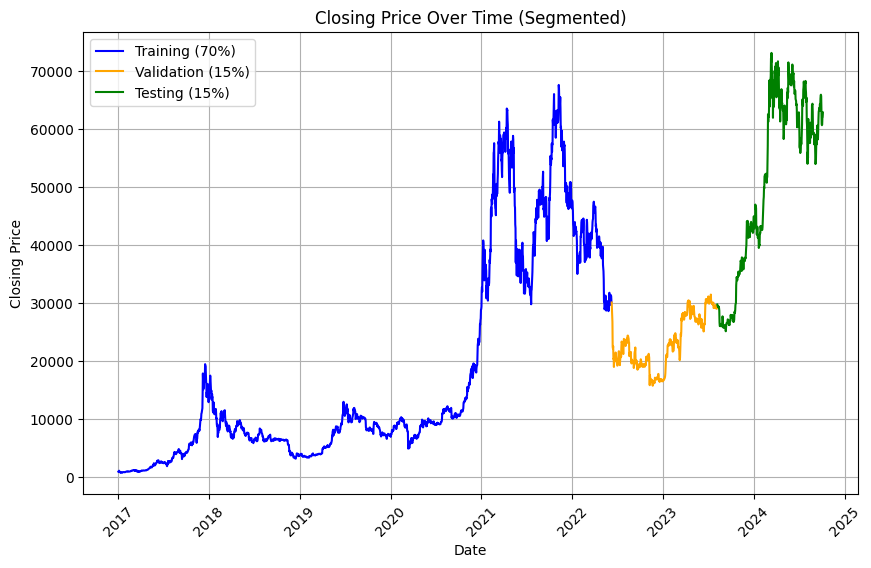

In [7]:
close_data = data['Close'].values  # Get 'Close' data as a NumPy array
total_data_points = len(close_data)
segment1_end = int(total_data_points * 0.7)
segment2_end = int(total_data_points * (0.7 + 0.15))

plt.figure(figsize=(10, 6))

# Plotting segments with different colors
plt.plot(data.index[:segment1_end], close_data[:segment1_end], label='Training (70%)', color='blue')
plt.plot(data.index[segment1_end:segment2_end], close_data[segment1_end:segment2_end], label='Validation (15%)', color='orange')
plt.plot(data.index[segment2_end:], close_data[segment2_end:], label='Testing (15%)', color='green')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Over Time (Segmented)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [8]:
def data_preprocessing_with_closed_price_and_min_max_scaler(data, seq_length=60):
    train_ratio = 0.7
    val_ratio = 0.15
    close_data = data["Close"].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 10))
    data_scaled = scaler.fit_transform(close_data)
    data_scaled = pd.DataFrame(data_scaled, columns=["Close"])

    def create_feature_datasets(data, x_size):
        x_datasets = []
        y_datasets = []
        for i in range(len(data) - x_size):
            x = data[i:i + x_size].values.reshape(-1, 1)
            y = data[i + x_size:i + x_size + 1].values.reshape(1)
            x_datasets.append(x)
            y_datasets.append(y)
        X = np.array(x_datasets)
        y = np.array(y_datasets)
        X_train =  X[:int(len(X) * train_ratio)]
        y_train = y[:int(len(y) * train_ratio)]
        X_val = X[int(len(X) * train_ratio):int(len(X) * (train_ratio + val_ratio))]
        y_val = y[int(len(y) * train_ratio):int(len(y) * (train_ratio + val_ratio))]
        X_test = X[int(len(X) * (train_ratio + val_ratio)):]
        y_test = y[int(len(y) * (train_ratio + val_ratio)):]

        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        return torch.Tensor(X_train_shuffled).to(device), torch.Tensor(X_val).to(device), torch.Tensor(X_test).to(device), torch.Tensor(y_train_shuffled).to(device), torch.Tensor(y_val).to(device), torch.Tensor(y_test).to(device)

    return create_feature_datasets(data_scaled, seq_length), scaler

(X_train, X_val, X_test, y_train, y_val, y_test), min_max_scaler = data_preprocessing_with_closed_price_and_min_max_scaler(data, 60)

# Baseline Model

In [9]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size

        # Input embedding to project input_size to hidden_size
        self.input_proj = nn.Linear(input_size, hidden_size)

        # Positional encoding for sequence information
        self.positional_encoding = PositionalEncoding(hidden_size, dropout)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=8, dim_feedforward=hidden_size*4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)

        # Project input to the hidden_size
        x = self.input_proj(x)

        # Apply positional encoding
        x = self.positional_encoding(x)

        # Transformer expects input in (seq_length, batch_size, hidden_size) format
        x = x.permute(1, 0, 2)  # Change to (seq_length, batch_size, hidden_size)

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Get the output from the last time step
        x = x[-1, :, :]  # Last time step, shape: (batch_size, hidden_size)

        # Fully connected layer
        x = self.fc(x)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, hidden_size)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-torch.log(torch.tensor(10000.0)) / hidden_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Training

In [14]:
# create a nn class (just-for-fun choice :-)
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:
# Hyperparameters
input_size = 5
hidden_size = 128
num_layers = 4
dropout = 0.2
output_size = 1
learning_rate = 0.0003
num_epochs = 200
batch_size = 64

# Create dataset and DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
model = TransformerModel(input_size, hidden_size, num_layers, output_size, dropout)
model.to(device)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_losses = []

# Training loop with batching
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    epoch_losses.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Visualization

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_train)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_train) ** 2))
print(f"Training Loss Scaling Unreversed: {rmse.item()}")

if device == torch.device("cuda"):
    predictions_cpu = predictions.cpu()
    y_train_cpu = y_train.cpu()

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions_cpu.numpy()))
y_train_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_train_cpu.numpy()))
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_train_reversed) ** 2))
print(f"Training Loss Scaling Reversed: {rmse_reversed.item()}")

In [ ]:

# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.scatter(tensor1.numpy(), tensor2.numpy(), label='Predictions vs GT', marker='o', s=10)

min_val = min(tensor1.min(), tensor2.min())
max_val = max(tensor1.max(), tensor2.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', label='Predictions = GT')

plt.title('Predictions vs GT on Training Set')
plt.xlabel('Predictions')
plt.ylabel('GT')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_val) ** 2))
print(f"Validation Loss Scaling Unreversed: {rmse.item()}")

if device == torch.device("cuda"):
    predictions_cpu = predictions.cpu()
    y_val_cpu = y_val.cpu()

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions_cpu.numpy()))
y_val_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_val_cpu.numpy()))
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_val_reversed) ** 2))
print(f"Validation Loss Scaling Reversed: {rmse_reversed.item()}")

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy(), label='Predictions', marker='x')
plt.plot(tensor2.numpy(), label='GT', marker='.')
plt.title('Predictions vs GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Return

In [ ]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_val_reversed.view(-1)

calculate_daily_long_trade_return_percentage(predicted_prices, true_prices)

In [ ]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_val_reversed.view(-1)

calculate_daily_short_trade_return_percentage(predicted_prices, true_prices)

# Tuning

In [10]:
def train_model(batch_size, hidden_size, num_layers, dropout, learning_rate, input_size=1, output_size=1, num_epochs=200):
  dataset = TensorDataset(X_train, y_train)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  # Model, loss, optimizer
  model = TransformerModel(input_size, hidden_size, num_layers, output_size, dropout)
  model = model.to(device)
  criterion = RMSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  epoch_losses = []

  # Training loop with batching
  for epoch in range(num_epochs):
      model.train()
      for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
          optimizer.zero_grad()
          outputs = model(batch_x)
          loss = criterion(outputs, batch_y)
          loss.backward()
          optimizer.step()

      epoch_losses.append(loss.item())
      if (epoch + 1) % 10 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  # # Visualization
  # plt.figure(figsize=(8, 6))
  # plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
  # plt.xlabel('Epoch')
  # plt.ylabel('Loss')
  # plt.title('Loss Curve')
  # plt.legend()
  # plt.grid()
  # plt.show()

  model.eval()
  with torch.no_grad():
      predictions = model(X_train)
      print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
  rmse = torch.sqrt(torch.mean((predictions - y_train) ** 2))
  print(f"Training Loss Scaling Unreversed: {rmse.item()}")

  if device == torch.device("cuda"):
      predictions_cpu = predictions.cpu()
      y_train_cpu = y_train.cpu()

  # Reverse the scaling
  predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions_cpu.numpy()))
  y_train_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_train_cpu.numpy()))
  rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_train_reversed) ** 2))
  print(f"Training Loss Scaling Reversed: {rmse_reversed.item()}")

  # # Convert tensors to 1D for plotting
  # tensor1 = predictions_reversed.view(-1)
  # tensor2 = y_train_reversed.view(-1)

  # # Plotting the line chart
  # plt.figure(figsize=(8, 5))
  # plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
  # plt.title('Differences between Predictions and GT on Training Set')
  # plt.xlabel('Index')
  # plt.ylabel('Value')
  # plt.legend()
  # plt.grid(True)
  # plt.show()

  model.eval()
  with torch.no_grad():
      predictions = model(X_val)
      print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
  rmse_val = torch.sqrt(torch.mean((predictions - y_val) ** 2))
  print(f"Validation Loss Scaling Unreversed: {rmse_val.item()}")

  if device == torch.device("cuda"):
      predictions_cpu = predictions.cpu()
      y_val_cpu = y_val.cpu()

  # Reverse the scaling
  predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions_cpu.numpy()))
  y_val_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_val_cpu.numpy()))
  rmse_reversed_val = torch.sqrt(torch.mean((predictions_reversed - y_val_reversed) ** 2))
  print(f"Validation Loss Scaling Reversed: {rmse_reversed_val.item()}")

  # # Convert tensors to 1D for plotting
  # tensor1 = predictions_reversed.view(-1)
  # tensor2 = y_val_reversed.view(-1)

  # # Plotting the line chart
  # plt.figure(figsize=(8, 5))
  # plt.plot(tensor1.numpy(), label='Predictions', marker='x')
  # plt.plot(tensor2.numpy(), label='GT', marker='.')
  # plt.title('Predictions vs GT on Validation Set')
  # plt.xlabel('Index')
  # plt.ylabel('Value')
  # plt.legend()
  # plt.grid(True)
  # plt.show()

  # # Convert tensors to 1D for plotting
  # tensor1 = predictions_reversed.view(-1)
  # tensor2 = y_val_reversed.view(-1)

  # # Plotting the line chart
  # plt.figure(figsize=(8, 5))
  # plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
  # plt.title('Differences between Predictions and GT on Validation Set')
  # plt.xlabel('Index')
  # plt.ylabel('Value')
  # plt.legend()
  # plt.grid(True)
  # plt.show()

  # Example usage:
  predicted_prices = predictions_reversed.view(-1)
  true_prices = y_val_reversed.view(-1)

  r, m = calculate_daily_long_trade_return_percentage(predicted_prices, true_prices)

  return rmse_val, rmse_reversed_val, rmse, rmse_reversed, r, m

In [15]:
df = pd.read_excel("/content/drive/MyDrive/24fall_dlProject/transformer_backward.xlsx", sheet_name=None)
df_sheet = df["transformer_5features"]

for index, row in df_sheet.iloc[::-1].iterrows():


# for index, row in df["transformer_5features"].iterrows():
  if not pd.isna(row["Val_loss_unreversed"]):
    continue
  batch_size = int(row["Batch_size"])
  hidden_size = int(row["Hidden_size"])
  num_layers = int(row["Num_layers"])
  dropout = float(row["Dropout"])
  learning_rate = float(row["Learning_rate"])

  v_loss, v_lossr, t_loss, t_lossr, ret, max_drawdown = train_model(batch_size, hidden_size, num_layers, dropout, learning_rate)
  df["transformer_5features"].at[index, "Val_loss_unreversed"] = v_loss.item()
  df["transformer_5features"].at[index, "Val_loss_reversed"] = v_lossr.item()
  df["transformer_5features"].at[index, "Train_loss_unreversed"] = t_loss.item()
  df["transformer_5features"].at[index, "Train_loss_reversed"] = t_lossr.item()
  df["transformer_5features"].at[index, "Return"] = ret
  df["transformer_5features"].at[index, "Max_drawdown"] = max_drawdown
  df["transformer_5features"].to_excel("/content/drive/MyDrive/24fall_dlProject/transformer_backward.xlsx", sheet_name="transformer_5features", index=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.7630
Epoch [20/200], Loss: 0.8301
Epoch [30/200], Loss: 0.2588
Epoch [40/200], Loss: 0.4175
Epoch [50/200], Loss: 0.8944
Epoch [60/200], Loss: 0.7076
Epoch [70/200], Loss: 0.5040
Epoch [80/200], Loss: 0.6300
Epoch [90/200], Loss: 0.3858
Epoch [100/200], Loss: 0.4502
Epoch [110/200], Loss: 0.4447
Epoch [120/200], Loss: 0.2677
Epoch [130/200], Loss: 0.1921
Epoch [140/200], Loss: 0.6373
Epoch [150/200], Loss: 0.4639
Epoch [160/200], Loss: 0.6389
Epoch [170/200], Loss: 0.4954
Epoch [180/200], Loss: 0.4588
Epoch [190/200], Loss: 0.1809
Epoch [200/200], Loss: 0.4034
Predicted value for the first sample: 2.4366
Training Loss Scaling Unreversed: 0.5347263216972351
Training Loss Scaling Reversed: 3866.37841796875
Predicted value for the first sample: 2.4089
Validation Loss Scaling Unreversed: 0.3257569968700409
Validation Loss Scaling Reversed: 2355.41015625
Return: 0.4581855535507202
Max Drawdown: -0.19989216327667236


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.7275
Epoch [20/200], Loss: 0.4251
Epoch [30/200], Loss: 0.4220
Epoch [40/200], Loss: 0.2155
Epoch [50/200], Loss: 0.3271
Epoch [60/200], Loss: 0.3912
Epoch [70/200], Loss: 0.2673
Epoch [80/200], Loss: 0.2349
Epoch [90/200], Loss: 0.2098
Epoch [100/200], Loss: 0.2715
Epoch [110/200], Loss: 0.2130
Epoch [120/200], Loss: 0.1504
Epoch [130/200], Loss: 0.2278
Epoch [140/200], Loss: 0.2067
Epoch [150/200], Loss: 0.2861
Epoch [160/200], Loss: 0.2127
Epoch [170/200], Loss: 0.2240
Epoch [180/200], Loss: 0.3374
Epoch [190/200], Loss: 0.2548
Epoch [200/200], Loss: 0.2302
Predicted value for the first sample: 2.2659
Training Loss Scaling Unreversed: 0.40656304359436035
Training Loss Scaling Reversed: 2939.684326171875
Predicted value for the first sample: 2.3961
Validation Loss Scaling Unreversed: 0.30379557609558105
Validation Loss Scaling Reversed: 2196.6162109375
Return: 0.48409879207611084
Max Drawdown: -0.21747083961963654


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.3311
Epoch [20/200], Loss: 0.5595
Epoch [30/200], Loss: 0.3534
Epoch [40/200], Loss: 0.5434
Epoch [50/200], Loss: 0.2810
Epoch [60/200], Loss: 0.3416
Epoch [70/200], Loss: 0.2332
Epoch [80/200], Loss: 0.2127
Epoch [90/200], Loss: 0.2417
Epoch [100/200], Loss: 0.2091
Epoch [110/200], Loss: 0.2051
Epoch [120/200], Loss: 0.1259
Epoch [130/200], Loss: 0.2210
Epoch [140/200], Loss: 0.2346
Epoch [150/200], Loss: 0.2909
Epoch [160/200], Loss: 0.2689
Epoch [170/200], Loss: 0.1899
Epoch [180/200], Loss: 0.2181
Epoch [190/200], Loss: 0.1406
Epoch [200/200], Loss: 0.1602
Predicted value for the first sample: 3.0610
Training Loss Scaling Unreversed: 0.3075352609157562
Training Loss Scaling Reversed: 2223.656494140625
Predicted value for the first sample: 3.2715
Validation Loss Scaling Unreversed: 0.58775794506073
Validation Loss Scaling Reversed: 4249.8271484375
Return: 0.34742486476898193
Max Drawdown: -0.1944045126438141


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.9542
Epoch [20/200], Loss: 0.6305
Epoch [30/200], Loss: 0.6102
Epoch [40/200], Loss: 0.4322
Epoch [50/200], Loss: 0.4694
Epoch [60/200], Loss: 0.7088
Epoch [70/200], Loss: 0.3581
Epoch [80/200], Loss: 0.2867
Epoch [90/200], Loss: 0.2927
Epoch [100/200], Loss: 0.5514
Epoch [110/200], Loss: 0.3818
Epoch [120/200], Loss: 0.2401
Epoch [130/200], Loss: 0.4677
Epoch [140/200], Loss: 0.3791
Epoch [150/200], Loss: 0.3862
Epoch [160/200], Loss: 0.5039
Epoch [170/200], Loss: 0.5712
Epoch [180/200], Loss: 0.4283
Epoch [190/200], Loss: 0.1572
Epoch [200/200], Loss: 0.3792
Predicted value for the first sample: 2.5324
Training Loss Scaling Unreversed: 0.38481396436691284
Training Loss Scaling Reversed: 2782.426025390625
Predicted value for the first sample: 2.4962
Validation Loss Scaling Unreversed: 0.1916372925043106
Validation Loss Scaling Reversed: 1385.6475830078125
Return: 0.7022296190261841
Max Drawdown: -0.21066810190677643


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.4736
Epoch [20/200], Loss: 0.2733
Epoch [30/200], Loss: 0.3699
Epoch [40/200], Loss: 0.2557
Epoch [50/200], Loss: 0.2449
Epoch [60/200], Loss: 0.3272
Epoch [70/200], Loss: 0.2575
Epoch [80/200], Loss: 0.2207
Epoch [90/200], Loss: 0.2799
Epoch [100/200], Loss: 0.3622
Epoch [110/200], Loss: 0.1997
Epoch [120/200], Loss: 0.2304
Epoch [130/200], Loss: 0.1370
Epoch [140/200], Loss: 0.1381
Epoch [150/200], Loss: 0.1459
Epoch [160/200], Loss: 0.1329
Epoch [170/200], Loss: 0.1577
Epoch [180/200], Loss: 0.1968
Epoch [190/200], Loss: 0.2730
Epoch [200/200], Loss: 0.2458
Predicted value for the first sample: 2.4092
Training Loss Scaling Unreversed: 0.39096224308013916
Training Loss Scaling Reversed: 2826.88134765625
Predicted value for the first sample: 2.6115
Validation Loss Scaling Unreversed: 0.18007510900497437
Validation Loss Scaling Reversed: 1302.0462646484375
Return: 0.3622713088989258
Max Drawdown: -0.22109371423721313


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.2832
Epoch [20/200], Loss: 0.2923
Epoch [30/200], Loss: 0.7216
Epoch [40/200], Loss: 0.4247
Epoch [50/200], Loss: 0.2641
Epoch [60/200], Loss: 0.2308
Epoch [70/200], Loss: 0.3212
Epoch [80/200], Loss: 0.3620
Epoch [90/200], Loss: 0.2209
Epoch [100/200], Loss: 0.3062
Epoch [110/200], Loss: 0.2535
Epoch [120/200], Loss: 0.2626
Epoch [130/200], Loss: 0.2644
Epoch [140/200], Loss: 0.2783
Epoch [150/200], Loss: 0.2421
Epoch [160/200], Loss: 0.2618
Epoch [170/200], Loss: 0.2888
Epoch [180/200], Loss: 0.4345
Epoch [190/200], Loss: 0.1816
Epoch [200/200], Loss: 0.2574
Predicted value for the first sample: 2.4828
Training Loss Scaling Unreversed: 0.23169922828674316
Training Loss Scaling Reversed: 1675.318603515625
Predicted value for the first sample: 2.6716
Validation Loss Scaling Unreversed: 0.14468736946582794
Validation Loss Scaling Reversed: 1046.1727294921875
Return: 0.4542950391769409
Max Drawdown: -0.21573154628276825


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 1.2057
Epoch [20/200], Loss: 0.4333
Epoch [30/200], Loss: 0.1970
Epoch [40/200], Loss: 0.4320
Epoch [50/200], Loss: 0.4606
Epoch [60/200], Loss: 0.5138
Epoch [70/200], Loss: 0.3924
Epoch [80/200], Loss: 0.4676
Epoch [90/200], Loss: 0.2583
Epoch [100/200], Loss: 0.3207
Epoch [110/200], Loss: 0.1757
Epoch [120/200], Loss: 0.2611
Epoch [130/200], Loss: 0.2987
Epoch [140/200], Loss: 0.3366
Epoch [150/200], Loss: 0.3495
Epoch [160/200], Loss: 0.1811
Epoch [170/200], Loss: 0.1910
Epoch [180/200], Loss: 0.2197
Epoch [190/200], Loss: 0.3210
Epoch [200/200], Loss: 0.2416
Predicted value for the first sample: 2.3917
Training Loss Scaling Unreversed: 0.3537353575229645
Training Loss Scaling Reversed: 2557.709716796875
Predicted value for the first sample: 2.4690
Validation Loss Scaling Unreversed: 0.18799255788326263
Validation Loss Scaling Reversed: 1359.294189453125
Return: 0.2820603847503662
Max Drawdown: -0.26396504044532776


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.3024
Epoch [20/200], Loss: 0.2949
Epoch [30/200], Loss: 0.2256
Epoch [40/200], Loss: 0.2641
Epoch [50/200], Loss: 0.1924
Epoch [60/200], Loss: 0.1775
Epoch [70/200], Loss: 0.3467
Epoch [80/200], Loss: 0.3976
Epoch [90/200], Loss: 0.1289
Epoch [100/200], Loss: 0.1905
Epoch [110/200], Loss: 0.2769
Epoch [120/200], Loss: 0.2122
Epoch [130/200], Loss: 0.1612
Epoch [140/200], Loss: 0.2418
Epoch [150/200], Loss: 0.2695
Epoch [160/200], Loss: 0.2743
Epoch [170/200], Loss: 0.1820
Epoch [180/200], Loss: 0.1546
Epoch [190/200], Loss: 0.2014
Epoch [200/200], Loss: 0.1897
Predicted value for the first sample: 2.4209
Training Loss Scaling Unreversed: 0.276300847530365
Training Loss Scaling Reversed: 1997.8138427734375
Predicted value for the first sample: 2.5888
Validation Loss Scaling Unreversed: 0.19181746244430542
Validation Loss Scaling Reversed: 1386.950439453125
Return: 0.3199915885925293
Max Drawdown: -0.20029491186141968


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.9372
Epoch [20/200], Loss: 0.3909
Epoch [30/200], Loss: 0.6814
Epoch [40/200], Loss: 0.6387
Epoch [50/200], Loss: 0.9991
Epoch [60/200], Loss: 0.9621
Epoch [70/200], Loss: 0.8597
Epoch [80/200], Loss: 0.8545
Epoch [90/200], Loss: 1.0030
Epoch [100/200], Loss: 0.7671
Epoch [110/200], Loss: 0.6577
Epoch [120/200], Loss: 1.2358
Epoch [130/200], Loss: 0.5880
Epoch [140/200], Loss: 1.0011
Epoch [150/200], Loss: 0.6630
Epoch [160/200], Loss: 0.6933
Epoch [170/200], Loss: 0.7917
Epoch [180/200], Loss: 0.6822
Epoch [190/200], Loss: 0.7713
Epoch [200/200], Loss: 0.6649
Predicted value for the first sample: 5.9317
Training Loss Scaling Unreversed: 1.0849584341049194
Training Loss Scaling Reversed: 7844.87255859375
Predicted value for the first sample: 5.9317
Validation Loss Scaling Unreversed: 2.880328893661499
Validation Loss Scaling Reversed: 20826.431640625
Return: -0.12073779106140137
Max Drawdown: -0.33367228507995605


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.9277
Epoch [20/200], Loss: 0.7968
Epoch [30/200], Loss: 0.5858
Epoch [40/200], Loss: 0.6080
Epoch [50/200], Loss: 0.2673
Epoch [60/200], Loss: 0.5691
Epoch [70/200], Loss: 0.6185
Epoch [80/200], Loss: 0.3611
Epoch [90/200], Loss: 0.4754
Epoch [100/200], Loss: 0.2836
Epoch [110/200], Loss: 0.3267
Epoch [120/200], Loss: 0.4244
Epoch [130/200], Loss: 0.5978
Epoch [140/200], Loss: 0.2392
Epoch [150/200], Loss: 0.2330
Epoch [160/200], Loss: 0.5576
Epoch [170/200], Loss: 0.4583
Epoch [180/200], Loss: 0.5305
Epoch [190/200], Loss: 0.2686
Epoch [200/200], Loss: 0.3294
Predicted value for the first sample: 2.6016
Training Loss Scaling Unreversed: 0.30705899000167847
Training Loss Scaling Reversed: 2220.212646484375
Predicted value for the first sample: 2.4741
Validation Loss Scaling Unreversed: 0.33053627610206604
Validation Loss Scaling Reversed: 2389.966796875
Return: 0.35803306102752686
Max Drawdown: -0.2481803297996521


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.5110
Epoch [20/200], Loss: 0.3124
Epoch [30/200], Loss: 0.2969
Epoch [40/200], Loss: 0.3936
Epoch [50/200], Loss: 0.2210
Epoch [60/200], Loss: 0.2340
Epoch [70/200], Loss: 0.3846
Epoch [80/200], Loss: 0.1691
Epoch [90/200], Loss: 0.2466
Epoch [100/200], Loss: 0.3649
Epoch [110/200], Loss: 0.1969
Epoch [120/200], Loss: 0.1765
Epoch [130/200], Loss: 0.3917
Epoch [140/200], Loss: 0.2093
Epoch [150/200], Loss: 0.3144
Epoch [160/200], Loss: 0.2564
Epoch [170/200], Loss: 0.2287
Epoch [180/200], Loss: 0.2884
Epoch [190/200], Loss: 0.4244
Epoch [200/200], Loss: 0.2351
Predicted value for the first sample: 2.1596
Training Loss Scaling Unreversed: 0.6863200068473816
Training Loss Scaling Reversed: 4962.48779296875
Predicted value for the first sample: 2.2769
Validation Loss Scaling Unreversed: 0.4806351661682129
Validation Loss Scaling Reversed: 3475.267822265625
Return: 0.42307913303375244
Max Drawdown: -0.18246515095233917


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.8802
Epoch [20/200], Loss: 0.9731
Epoch [30/200], Loss: 0.6945
Epoch [40/200], Loss: 0.9873
Epoch [50/200], Loss: 2.5191
Epoch [60/200], Loss: 2.2081
Epoch [70/200], Loss: 2.8489
Epoch [80/200], Loss: 2.2682
Epoch [90/200], Loss: 2.3836
Epoch [100/200], Loss: 2.0578
Epoch [110/200], Loss: 0.7524
Epoch [120/200], Loss: 1.1040
Epoch [130/200], Loss: 1.3816
Epoch [140/200], Loss: 0.6782
Epoch [150/200], Loss: 1.0459
Epoch [160/200], Loss: 0.9485
Epoch [170/200], Loss: 0.9081
Epoch [180/200], Loss: 1.4540
Epoch [190/200], Loss: 3.1890
Epoch [200/200], Loss: 2.2449
Predicted value for the first sample: 2.7271
Training Loss Scaling Unreversed: 2.4463133811950684
Training Loss Scaling Reversed: 17688.25
Predicted value for the first sample: 2.7271
Validation Loss Scaling Unreversed: 0.7395449280738831
Validation Loss Scaling Reversed: 5347.33447265625
Return: 0.3503662347793579
Max Drawdown: -0.15877503156661987


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.5166
Epoch [20/200], Loss: 0.7734
Epoch [30/200], Loss: 0.2322
Epoch [40/200], Loss: 0.3467
Epoch [50/200], Loss: 0.4732
Epoch [60/200], Loss: 0.2648
Epoch [70/200], Loss: 0.3046
Epoch [80/200], Loss: 0.3730
Epoch [90/200], Loss: 0.2779
Epoch [100/200], Loss: 0.3577
Epoch [110/200], Loss: 0.2126
Epoch [120/200], Loss: 0.3058
Epoch [130/200], Loss: 0.2995
Epoch [140/200], Loss: 0.3308
Epoch [150/200], Loss: 0.4513
Epoch [160/200], Loss: 0.2242
Epoch [170/200], Loss: 0.2931
Epoch [180/200], Loss: 0.2307
Epoch [190/200], Loss: 0.3897
Epoch [200/200], Loss: 0.1835
Predicted value for the first sample: 2.3979
Training Loss Scaling Unreversed: 0.483015239238739
Training Loss Scaling Reversed: 3492.4775390625
Predicted value for the first sample: 2.2772
Validation Loss Scaling Unreversed: 0.27036017179489136
Validation Loss Scaling Reversed: 1954.8592529296875
Return: 0.2256183624267578
Max Drawdown: -0.2512592077255249


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.5349
Epoch [20/200], Loss: 0.3169
Epoch [30/200], Loss: 0.3394
Epoch [40/200], Loss: 0.2511
Epoch [50/200], Loss: 0.2570
Epoch [60/200], Loss: 0.2759
Epoch [70/200], Loss: 0.2415
Epoch [80/200], Loss: 0.1675
Epoch [90/200], Loss: 0.4223
Epoch [100/200], Loss: 0.3243
Epoch [110/200], Loss: 0.2174
Epoch [120/200], Loss: 0.2439
Epoch [130/200], Loss: 0.2240
Epoch [140/200], Loss: 0.2250
Epoch [150/200], Loss: 0.1196
Epoch [160/200], Loss: 0.1806
Epoch [170/200], Loss: 0.1259
Epoch [180/200], Loss: 0.1748
Epoch [190/200], Loss: 0.2194
Epoch [200/200], Loss: 0.1405
Predicted value for the first sample: 2.4063
Training Loss Scaling Unreversed: 0.2667234241962433
Training Loss Scaling Reversed: 1928.5634765625
Predicted value for the first sample: 2.5595
Validation Loss Scaling Unreversed: 0.2139396071434021
Validation Loss Scaling Reversed: 1546.90625
Return: 0.4878818988800049
Max Drawdown: -0.21214233338832855


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 1.1291
Epoch [20/200], Loss: 0.8786
Epoch [30/200], Loss: 0.6580
Epoch [40/200], Loss: 0.8997
Epoch [50/200], Loss: 0.8678
Epoch [60/200], Loss: 0.8828
Epoch [70/200], Loss: 1.0310
Epoch [80/200], Loss: 0.9324
Epoch [90/200], Loss: 0.8999
Epoch [100/200], Loss: 0.9068
Epoch [110/200], Loss: 0.7226
Epoch [120/200], Loss: 0.6387
Epoch [130/200], Loss: 0.8913
Epoch [140/200], Loss: 0.5123
Epoch [150/200], Loss: 0.7884
Epoch [160/200], Loss: 0.9435
Epoch [170/200], Loss: 0.8370
Epoch [180/200], Loss: 0.8786
Epoch [190/200], Loss: 1.6088
Epoch [200/200], Loss: 2.0452
Predicted value for the first sample: 2.6912
Training Loss Scaling Unreversed: 2.4413630962371826
Training Loss Scaling Reversed: 17652.455078125
Predicted value for the first sample: 2.6912
Validation Loss Scaling Unreversed: 0.7592593431472778
Validation Loss Scaling Reversed: 5489.880859375
Return: -0.3026888370513916
Max Drawdown: -0.398021399974823


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.6467
Epoch [20/200], Loss: 0.4766
Epoch [30/200], Loss: 0.4785
Epoch [40/200], Loss: 0.5555
Epoch [50/200], Loss: 0.4237
Epoch [60/200], Loss: 0.3705
Epoch [70/200], Loss: 0.2985
Epoch [80/200], Loss: 0.2886
Epoch [90/200], Loss: 0.2361
Epoch [100/200], Loss: 0.3835
Epoch [110/200], Loss: 0.3065
Epoch [120/200], Loss: 0.4494
Epoch [130/200], Loss: 0.2598
Epoch [140/200], Loss: 0.3690
Epoch [150/200], Loss: 0.2481
Epoch [160/200], Loss: 0.3929
Epoch [170/200], Loss: 0.1404
Epoch [180/200], Loss: 0.1971
Epoch [190/200], Loss: 0.2634
Epoch [200/200], Loss: 0.2678
Predicted value for the first sample: 2.4609
Training Loss Scaling Unreversed: 0.23380035161972046
Training Loss Scaling Reversed: 1690.5107421875
Predicted value for the first sample: 2.5222
Validation Loss Scaling Unreversed: 0.1556500941514969
Validation Loss Scaling Reversed: 1125.4395751953125
Return: 0.24554622173309326
Max Drawdown: -0.24529898166656494


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.4431
Epoch [20/200], Loss: 0.1710
Epoch [30/200], Loss: 0.2079
Epoch [40/200], Loss: 0.2150
Epoch [50/200], Loss: 0.1605
Epoch [60/200], Loss: 0.2863
Epoch [70/200], Loss: 0.1332
Epoch [80/200], Loss: 0.1473
Epoch [90/200], Loss: 0.1821
Epoch [100/200], Loss: 0.2156
Epoch [110/200], Loss: 0.1489
Epoch [120/200], Loss: 0.0959
Epoch [130/200], Loss: 0.1592
Epoch [140/200], Loss: 0.1624
Epoch [150/200], Loss: 0.1670
Epoch [160/200], Loss: 0.3119
Epoch [170/200], Loss: 0.1592
Epoch [180/200], Loss: 0.1193
Epoch [190/200], Loss: 0.3104
Epoch [200/200], Loss: 0.1054
Predicted value for the first sample: 2.4626
Training Loss Scaling Unreversed: 0.2660248577594757
Training Loss Scaling Reversed: 1923.5126953125
Predicted value for the first sample: 2.5599
Validation Loss Scaling Unreversed: 0.14064554870128632
Validation Loss Scaling Reversed: 1016.947998046875
Return: 0.33085501194000244
Max Drawdown: -0.2293788492679596


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.1777
Epoch [20/200], Loss: 0.1970
Epoch [30/200], Loss: 0.3460
Epoch [40/200], Loss: 0.3130
Epoch [50/200], Loss: 0.1929
Epoch [60/200], Loss: 0.2038
Epoch [70/200], Loss: 0.1883
Epoch [80/200], Loss: 0.1820
Epoch [90/200], Loss: 0.1936
Epoch [100/200], Loss: 0.3520
Epoch [110/200], Loss: 0.1578
Epoch [120/200], Loss: 0.2429
Epoch [130/200], Loss: 0.1235
Epoch [140/200], Loss: 0.1775
Epoch [150/200], Loss: 0.2323
Epoch [160/200], Loss: 0.1697
Epoch [170/200], Loss: 0.2060
Epoch [180/200], Loss: 0.1597
Epoch [190/200], Loss: 0.2118
Epoch [200/200], Loss: 0.2462
Predicted value for the first sample: 3.0144
Training Loss Scaling Unreversed: 0.2438650280237198
Training Loss Scaling Reversed: 1763.2841796875
Predicted value for the first sample: 3.2455
Validation Loss Scaling Unreversed: 0.4516947567462921
Validation Loss Scaling Reversed: 3266.01220703125
Return: 0.2561708688735962
Max Drawdown: -0.24299611151218414


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 1.4005
Epoch [20/200], Loss: 0.2689
Epoch [30/200], Loss: 0.4274
Epoch [40/200], Loss: 0.3814
Epoch [50/200], Loss: 0.2999
Epoch [60/200], Loss: 0.1590
Epoch [70/200], Loss: 0.1313
Epoch [80/200], Loss: 0.2683
Epoch [90/200], Loss: 0.3725
Epoch [100/200], Loss: 0.3236
Epoch [110/200], Loss: 0.3666
Epoch [120/200], Loss: 0.1941
Epoch [130/200], Loss: 0.5298
Epoch [140/200], Loss: 0.2123
Epoch [150/200], Loss: 0.2270
Epoch [160/200], Loss: 0.1556
Epoch [170/200], Loss: 0.1077
Epoch [180/200], Loss: 0.0867
Epoch [190/200], Loss: 0.1375
Epoch [200/200], Loss: 0.2058
Predicted value for the first sample: 2.2210
Training Loss Scaling Unreversed: 0.6743907332420349
Training Loss Scaling Reversed: 4876.23193359375
Predicted value for the first sample: 2.0646
Validation Loss Scaling Unreversed: 0.4488070011138916
Validation Loss Scaling Reversed: 3245.13232421875
Return: 0.5063308477401733
Max Drawdown: -0.2534925937652588


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.3055
Epoch [20/200], Loss: 0.5499
Epoch [30/200], Loss: 0.3823
Epoch [40/200], Loss: 0.4313
Epoch [50/200], Loss: 0.1668
Epoch [60/200], Loss: 0.2788
Epoch [70/200], Loss: 0.1978
Epoch [80/200], Loss: 0.1048
Epoch [90/200], Loss: 0.1560
Epoch [100/200], Loss: 0.2986
Epoch [110/200], Loss: 0.3636
Epoch [120/200], Loss: 0.1299
Epoch [130/200], Loss: 0.2574
Epoch [140/200], Loss: 0.2129
Epoch [150/200], Loss: 0.1504
Epoch [160/200], Loss: 0.1747
Epoch [170/200], Loss: 0.2988
Epoch [180/200], Loss: 0.1031
Epoch [190/200], Loss: 0.2364
Epoch [200/200], Loss: 0.1726
Predicted value for the first sample: 2.6294
Training Loss Scaling Unreversed: 0.23338475823402405
Training Loss Scaling Reversed: 1687.505859375
Predicted value for the first sample: 2.6842
Validation Loss Scaling Unreversed: 0.2756216824054718
Validation Loss Scaling Reversed: 1992.903076171875
Return: 0.5510004758834839
Max Drawdown: -0.1572192758321762


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.6297
Epoch [20/200], Loss: 1.5548
Epoch [30/200], Loss: 3.1921
Epoch [40/200], Loss: 3.1911
Epoch [50/200], Loss: 2.4740
Epoch [60/200], Loss: 1.9764
Epoch [70/200], Loss: 1.8431
Epoch [80/200], Loss: 1.7946
Epoch [90/200], Loss: 2.7428
Epoch [100/200], Loss: 2.5801
Epoch [110/200], Loss: 1.9040
Epoch [120/200], Loss: 2.8121
Epoch [130/200], Loss: 1.9066
Epoch [140/200], Loss: 1.9433
Epoch [150/200], Loss: 3.3507
Epoch [160/200], Loss: 3.0010
Epoch [170/200], Loss: 1.6340
Epoch [180/200], Loss: 2.0704
Epoch [190/200], Loss: 1.8414
Epoch [200/200], Loss: 2.4718
Predicted value for the first sample: 2.6078
Training Loss Scaling Unreversed: 2.431882619857788
Training Loss Scaling Reversed: 17583.90625
Predicted value for the first sample: 2.6078
Validation Loss Scaling Unreversed: 0.8093221783638
Validation Loss Scaling Reversed: 5851.865234375
Return: -0.30566805601119995
Max Drawdown: -0.37469127774238586


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.9416
Epoch [20/200], Loss: 0.5519
Epoch [30/200], Loss: 0.3034
Epoch [40/200], Loss: 0.3272
Epoch [50/200], Loss: 0.3009
Epoch [60/200], Loss: 0.1108
Epoch [70/200], Loss: 0.2274
Epoch [80/200], Loss: 0.2973
Epoch [90/200], Loss: 0.1339
Epoch [100/200], Loss: 0.4230
Epoch [110/200], Loss: 0.1665
Epoch [120/200], Loss: 0.0930
Epoch [130/200], Loss: 0.1691
Epoch [140/200], Loss: 0.4353
Epoch [150/200], Loss: 0.5335
Epoch [160/200], Loss: 0.2567
Epoch [170/200], Loss: 0.1333
Epoch [180/200], Loss: 0.1288
Epoch [190/200], Loss: 0.1909
Epoch [200/200], Loss: 0.0887
Predicted value for the first sample: 2.4006
Training Loss Scaling Unreversed: 0.36106637120246887
Training Loss Scaling Reversed: 2610.71728515625
Predicted value for the first sample: 2.5633
Validation Loss Scaling Unreversed: 0.20427732169628143
Validation Loss Scaling Reversed: 1477.042236328125
Return: 0.3051861524581909
Max Drawdown: -0.2880559265613556


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.2617
Epoch [20/200], Loss: 0.0969
Epoch [30/200], Loss: 0.3777
Epoch [40/200], Loss: 0.1015
Epoch [50/200], Loss: 0.1163
Epoch [60/200], Loss: 0.1386
Epoch [70/200], Loss: 0.2260
Epoch [80/200], Loss: 0.4144
Epoch [90/200], Loss: 0.3343
Epoch [100/200], Loss: 0.2975
Epoch [110/200], Loss: 0.1423
Epoch [120/200], Loss: 0.2872
Epoch [130/200], Loss: 0.1069
Epoch [140/200], Loss: 0.3745
Epoch [150/200], Loss: 0.1669
Epoch [160/200], Loss: 0.1283
Epoch [170/200], Loss: 0.1788
Epoch [180/200], Loss: 0.0862
Epoch [190/200], Loss: 0.0707
Epoch [200/200], Loss: 0.0740
Predicted value for the first sample: 2.4997
Training Loss Scaling Unreversed: 0.22837324440479279
Training Loss Scaling Reversed: 1651.269775390625
Predicted value for the first sample: 2.7009
Validation Loss Scaling Unreversed: 0.24571958184242249
Validation Loss Scaling Reversed: 1776.693603515625
Return: 0.39814817905426025
Max Drawdown: -0.2495238333940506


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 1.0957
Epoch [20/200], Loss: 1.5461
Epoch [30/200], Loss: 2.4188
Epoch [40/200], Loss: 1.5789
Epoch [50/200], Loss: 1.3240
Epoch [60/200], Loss: 1.9699
Epoch [70/200], Loss: 1.7369
Epoch [80/200], Loss: 3.2982
Epoch [90/200], Loss: 4.0334
Epoch [100/200], Loss: 2.6660
Epoch [110/200], Loss: 3.0385
Epoch [120/200], Loss: 2.9429
Epoch [130/200], Loss: 2.1397
Epoch [140/200], Loss: 1.2992
Epoch [150/200], Loss: 2.7585
Epoch [160/200], Loss: 1.3946
Epoch [170/200], Loss: 2.6622
Epoch [180/200], Loss: 2.2814
Epoch [190/200], Loss: 1.5966
Epoch [200/200], Loss: 2.0503
Predicted value for the first sample: 2.7983
Training Loss Scaling Unreversed: 2.4576339721679688
Training Loss Scaling Reversed: 17770.103515625
Predicted value for the first sample: 2.7983
Validation Loss Scaling Unreversed: 0.704309344291687
Validation Loss Scaling Reversed: 5092.56103515625
Return: 0.402917742729187
Max Drawdown: -0.11762715131044388


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.5384
Epoch [20/200], Loss: 0.2458
Epoch [30/200], Loss: 0.3667
Epoch [40/200], Loss: 0.1203
Epoch [50/200], Loss: 0.3849
Epoch [60/200], Loss: 0.2131
Epoch [70/200], Loss: 0.2878
Epoch [80/200], Loss: 0.1284
Epoch [90/200], Loss: 0.0726
Epoch [100/200], Loss: 0.1011
Epoch [110/200], Loss: 0.3422
Epoch [120/200], Loss: 0.1071
Epoch [130/200], Loss: 0.0562
Epoch [140/200], Loss: 0.2895
Epoch [150/200], Loss: 0.2433
Epoch [160/200], Loss: 0.0974
Epoch [170/200], Loss: 0.2361
Epoch [180/200], Loss: 0.1589
Epoch [190/200], Loss: 0.2244
Epoch [200/200], Loss: 0.1521
Predicted value for the first sample: 2.4879
Training Loss Scaling Unreversed: 0.19126147031784058
Training Loss Scaling Reversed: 1382.9302978515625
Predicted value for the first sample: 2.6716
Validation Loss Scaling Unreversed: 0.15093642473220825
Validation Loss Scaling Reversed: 1091.35693359375
Return: 0.2630957365036011
Max Drawdown: -0.2605920433998108


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.0733
Epoch [20/200], Loss: 0.1714
Epoch [30/200], Loss: 0.1383
Epoch [40/200], Loss: 0.1322
Epoch [50/200], Loss: 0.2468
Epoch [60/200], Loss: 0.1111
Epoch [70/200], Loss: 0.0996
Epoch [80/200], Loss: 0.3428
Epoch [90/200], Loss: 0.0887
Epoch [100/200], Loss: 0.2136
Epoch [110/200], Loss: 0.1135
Epoch [120/200], Loss: 0.2948
Epoch [130/200], Loss: 0.0799
Epoch [140/200], Loss: 0.1255
Epoch [150/200], Loss: 0.1405
Epoch [160/200], Loss: 0.2161
Epoch [170/200], Loss: 0.2150
Epoch [180/200], Loss: 0.2749
Epoch [190/200], Loss: 0.1882
Epoch [200/200], Loss: 0.0761
Predicted value for the first sample: 2.5390
Training Loss Scaling Unreversed: 0.1997295618057251
Training Loss Scaling Reversed: 1444.159423828125
Predicted value for the first sample: 2.8469
Validation Loss Scaling Unreversed: 0.13292506337165833
Validation Loss Scaling Reversed: 961.1245727539062
Return: 0.4580754041671753
Max Drawdown: -0.21032926440238953


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 2.1620
Epoch [20/200], Loss: 0.8674
Epoch [30/200], Loss: 1.4116
Epoch [40/200], Loss: 1.3451
Epoch [50/200], Loss: 1.1387
Epoch [60/200], Loss: 2.1818
Epoch [70/200], Loss: 1.3077
Epoch [80/200], Loss: 2.7751
Epoch [90/200], Loss: 1.9401
Epoch [100/200], Loss: 1.5041
Epoch [110/200], Loss: 2.1111
Epoch [120/200], Loss: 2.5815
Epoch [130/200], Loss: 3.3447
Epoch [140/200], Loss: 2.2546
Epoch [150/200], Loss: 3.5076
Epoch [160/200], Loss: 2.0175
Epoch [170/200], Loss: 2.2734
Epoch [180/200], Loss: 2.8279
Epoch [190/200], Loss: 2.5786
Epoch [200/200], Loss: 3.1270
Predicted value for the first sample: 2.4085
Training Loss Scaling Unreversed: 2.4207420349121094
Training Loss Scaling Reversed: 17503.357421875
Predicted value for the first sample: 2.4085
Validation Loss Scaling Unreversed: 0.9481527805328369
Validation Loss Scaling Reversed: 6855.68896484375
Return: 0.13996362686157227
Max Drawdown: -0.16978415846824646


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.6800
Epoch [20/200], Loss: 0.2016
Epoch [30/200], Loss: 0.8448
Epoch [40/200], Loss: 0.5112
Epoch [50/200], Loss: 0.1192
Epoch [60/200], Loss: 0.2709
Epoch [70/200], Loss: 0.1693
Epoch [80/200], Loss: 0.4503
Epoch [90/200], Loss: 0.1894
Epoch [100/200], Loss: 0.6817
Epoch [110/200], Loss: 0.4566
Epoch [120/200], Loss: 0.1518
Epoch [130/200], Loss: 0.1836
Epoch [140/200], Loss: 0.7171
Epoch [150/200], Loss: 0.1936
Epoch [160/200], Loss: 0.1346
Epoch [170/200], Loss: 0.0695
Epoch [180/200], Loss: 0.1072
Epoch [190/200], Loss: 0.1823
Epoch [200/200], Loss: 0.1552
Predicted value for the first sample: 2.1769
Training Loss Scaling Unreversed: 0.6982657313346863
Training Loss Scaling Reversed: 5048.8623046875
Predicted value for the first sample: 2.2880
Validation Loss Scaling Unreversed: 0.35685181617736816
Validation Loss Scaling Reversed: 2580.243408203125
Return: 0.48724234104156494
Max Drawdown: -0.21833984553813934


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.2207
Epoch [20/200], Loss: 0.2814
Epoch [30/200], Loss: 0.2874
Epoch [40/200], Loss: 0.2600
Epoch [50/200], Loss: 0.2619
Epoch [60/200], Loss: 0.0704
Epoch [70/200], Loss: 0.0875
Epoch [80/200], Loss: 0.1421
Epoch [90/200], Loss: 0.7990
Epoch [100/200], Loss: 0.1269
Epoch [110/200], Loss: 0.1769
Epoch [120/200], Loss: 0.0254
Epoch [130/200], Loss: 0.1781
Epoch [140/200], Loss: 0.0428
Epoch [150/200], Loss: 0.1155
Epoch [160/200], Loss: 0.0839
Epoch [170/200], Loss: 0.1150
Epoch [180/200], Loss: 0.0571
Epoch [190/200], Loss: 0.0461
Epoch [200/200], Loss: 0.1078
Predicted value for the first sample: 2.7326
Training Loss Scaling Unreversed: 0.1886880248785019
Training Loss Scaling Reversed: 1364.32275390625
Predicted value for the first sample: 2.9711
Validation Loss Scaling Unreversed: 0.2757555842399597
Validation Loss Scaling Reversed: 1993.87109375
Return: 0.3709862232208252
Max Drawdown: -0.22430633008480072


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 4.1547
Epoch [20/200], Loss: 3.6837
Epoch [30/200], Loss: 1.0144
Epoch [40/200], Loss: 0.3916
Epoch [50/200], Loss: 3.4958
Epoch [60/200], Loss: 0.7528
Epoch [70/200], Loss: 1.2160
Epoch [80/200], Loss: 1.7975
Epoch [90/200], Loss: 2.3472
Epoch [100/200], Loss: 1.3511
Epoch [110/200], Loss: 1.3843
Epoch [120/200], Loss: 3.3266
Epoch [130/200], Loss: 0.6584
Epoch [140/200], Loss: 0.9871
Epoch [150/200], Loss: 2.7182
Epoch [160/200], Loss: 1.8342
Epoch [170/200], Loss: 4.7773
Epoch [180/200], Loss: 3.2527
Epoch [190/200], Loss: 1.1902
Epoch [200/200], Loss: 2.4609
Predicted value for the first sample: 2.2988
Training Loss Scaling Unreversed: 2.4215965270996094
Training Loss Scaling Reversed: 17509.533203125
Predicted value for the first sample: 2.2988
Validation Loss Scaling Unreversed: 1.0330278873443604
Validation Loss Scaling Reversed: 7469.38427734375
Return: 0.14701759815216064
Max Drawdown: -0.026132000610232353


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 1.0978
Epoch [20/200], Loss: 0.3705
Epoch [30/200], Loss: 0.0704
Epoch [40/200], Loss: 0.6589
Epoch [50/200], Loss: 0.5745
Epoch [60/200], Loss: 0.1349
Epoch [70/200], Loss: 0.1455
Epoch [80/200], Loss: 0.0709
Epoch [90/200], Loss: 0.4888
Epoch [100/200], Loss: 0.0684
Epoch [110/200], Loss: 0.9695
Epoch [120/200], Loss: 0.0701
Epoch [130/200], Loss: 0.2485
Epoch [140/200], Loss: 0.1108
Epoch [150/200], Loss: 0.7213
Epoch [160/200], Loss: 0.3224
Epoch [170/200], Loss: 0.3802
Epoch [180/200], Loss: 0.1259
Epoch [190/200], Loss: 0.1542
Epoch [200/200], Loss: 0.0969
Predicted value for the first sample: 2.3368
Training Loss Scaling Unreversed: 0.42332637310028076
Training Loss Scaling Reversed: 3060.892822265625
Predicted value for the first sample: 2.5137
Validation Loss Scaling Unreversed: 0.28049173951148987
Validation Loss Scaling Reversed: 2028.1163330078125
Return: 0.3878304958343506
Max Drawdown: -0.24083569645881653


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.2437
Epoch [20/200], Loss: 0.1722
Epoch [30/200], Loss: 0.1217
Epoch [40/200], Loss: 0.1889
Epoch [50/200], Loss: 0.1957
Epoch [60/200], Loss: 0.0555
Epoch [70/200], Loss: 0.2602
Epoch [80/200], Loss: 0.3501
Epoch [90/200], Loss: 0.0393
Epoch [100/200], Loss: 0.0878
Epoch [110/200], Loss: 0.0991
Epoch [120/200], Loss: 0.1020
Epoch [130/200], Loss: 0.0294
Epoch [140/200], Loss: 0.2334
Epoch [150/200], Loss: 0.0278
Epoch [160/200], Loss: 0.1681
Epoch [170/200], Loss: 0.1200
Epoch [180/200], Loss: 0.2472
Epoch [190/200], Loss: 0.1695
Epoch [200/200], Loss: 0.0404
Predicted value for the first sample: 2.7387
Training Loss Scaling Unreversed: 0.22007037699222565
Training Loss Scaling Reversed: 1591.235107421875
Predicted value for the first sample: 2.9383
Validation Loss Scaling Unreversed: 0.26655998826026917
Validation Loss Scaling Reversed: 1927.381591796875
Return: 0.3182530403137207
Max Drawdown: -0.22771042585372925


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 4.9997
Epoch [20/200], Loss: 2.7554
Epoch [30/200], Loss: 2.2810
Epoch [40/200], Loss: 0.6560
Epoch [50/200], Loss: 2.5340
Epoch [60/200], Loss: 1.9693
Epoch [70/200], Loss: 1.0892
Epoch [80/200], Loss: 2.3663
Epoch [90/200], Loss: 2.8028
Epoch [100/200], Loss: 2.1980
Epoch [110/200], Loss: 3.1449
Epoch [120/200], Loss: 2.0610
Epoch [130/200], Loss: 1.4147
Epoch [140/200], Loss: 1.1071
Epoch [150/200], Loss: 2.6079
Epoch [160/200], Loss: 3.7565
Epoch [170/200], Loss: 1.7359
Epoch [180/200], Loss: 5.5762
Epoch [190/200], Loss: 3.7070
Epoch [200/200], Loss: 2.8830
Predicted value for the first sample: 1.8811
Training Loss Scaling Unreversed: 2.46985125541687
Training Loss Scaling Reversed: 17858.443359375
Predicted value for the first sample: 1.8811
Validation Loss Scaling Unreversed: 1.3884714841842651
Validation Loss Scaling Reversed: 10039.4462890625
Return: 0.6904916763305664
Max Drawdown: -0.04476146399974823


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.6740
Epoch [20/200], Loss: 0.1034
Epoch [30/200], Loss: 0.4209
Epoch [40/200], Loss: 0.0708
Epoch [50/200], Loss: 0.5289
Epoch [60/200], Loss: 0.1149
Epoch [70/200], Loss: 0.2441
Epoch [80/200], Loss: 0.0530
Epoch [90/200], Loss: 0.4421
Epoch [100/200], Loss: 0.5289
Epoch [110/200], Loss: 0.2959
Epoch [120/200], Loss: 0.1662
Epoch [130/200], Loss: 0.0696
Epoch [140/200], Loss: 0.1599
Epoch [150/200], Loss: 0.0478
Epoch [160/200], Loss: 0.0955
Epoch [170/200], Loss: 0.0994
Epoch [180/200], Loss: 0.1449
Epoch [190/200], Loss: 0.0122
Epoch [200/200], Loss: 0.1809
Predicted value for the first sample: 2.6168
Training Loss Scaling Unreversed: 0.163211390376091
Training Loss Scaling Reversed: 1180.112060546875
Predicted value for the first sample: 2.8267
Validation Loss Scaling Unreversed: 0.21440160274505615
Validation Loss Scaling Reversed: 1550.2467041015625
Return: 0.2812676429748535
Max Drawdown: -0.22698277235031128


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.0171
Epoch [20/200], Loss: 0.0448
Epoch [30/200], Loss: 0.0436
Epoch [40/200], Loss: 0.1200
Epoch [50/200], Loss: 0.0753
Epoch [60/200], Loss: 0.1486
Epoch [70/200], Loss: 0.0577
Epoch [80/200], Loss: 0.3784
Epoch [90/200], Loss: 0.3881
Epoch [100/200], Loss: 0.1132
Epoch [110/200], Loss: 0.3020
Epoch [120/200], Loss: 0.0505
Epoch [130/200], Loss: 0.1460
Epoch [140/200], Loss: 0.0509
Epoch [150/200], Loss: 0.0400
Epoch [160/200], Loss: 0.0979
Epoch [170/200], Loss: 0.1487
Epoch [180/200], Loss: 0.2040
Epoch [190/200], Loss: 0.0764
Epoch [200/200], Loss: 0.0858
Predicted value for the first sample: 2.7092
Training Loss Scaling Unreversed: 0.14170588552951813
Training Loss Scaling Reversed: 1024.6148681640625
Predicted value for the first sample: 2.9430
Validation Loss Scaling Unreversed: 0.30544179677963257
Validation Loss Scaling Reversed: 2208.51953125
Return: 0.39632201194763184
Max Drawdown: -0.2242610603570938


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 2.7039
Epoch [20/200], Loss: 1.8341
Epoch [30/200], Loss: 0.9133
Epoch [40/200], Loss: 3.2122
Epoch [50/200], Loss: 1.0762
Epoch [60/200], Loss: 1.3906
Epoch [70/200], Loss: 1.1056
Epoch [80/200], Loss: 1.7554
Epoch [90/200], Loss: 0.9885
Epoch [100/200], Loss: 0.8657
Epoch [110/200], Loss: 1.5046
Epoch [120/200], Loss: 0.7620
Epoch [130/200], Loss: 1.1868
Epoch [140/200], Loss: 2.3205
Epoch [150/200], Loss: 0.5161
Epoch [160/200], Loss: 0.8629
Epoch [170/200], Loss: 3.2027
Epoch [180/200], Loss: 3.5933
Epoch [190/200], Loss: 3.3369
Epoch [200/200], Loss: 1.6662
Predicted value for the first sample: 1.9012
Training Loss Scaling Unreversed: 2.4659366607666016
Training Loss Scaling Reversed: 17830.13671875
Predicted value for the first sample: 1.9012
Validation Loss Scaling Unreversed: 1.370589017868042
Validation Loss Scaling Reversed: 9910.1455078125
Return: -0.07418644428253174
Max Drawdown: -0.2503474950790405


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 2.5244
Epoch [20/200], Loss: 1.1996
Epoch [30/200], Loss: 1.2688
Epoch [40/200], Loss: 1.2277
Epoch [50/200], Loss: 1.1867
Epoch [60/200], Loss: 0.6004
Epoch [70/200], Loss: 1.1363
Epoch [80/200], Loss: 1.0737
Epoch [90/200], Loss: 0.8583
Epoch [100/200], Loss: 0.5055
Epoch [110/200], Loss: 0.5407
Epoch [120/200], Loss: 0.5507
Epoch [130/200], Loss: 0.9441
Epoch [140/200], Loss: 0.6689
Epoch [150/200], Loss: 0.6651
Epoch [160/200], Loss: 0.5836
Epoch [170/200], Loss: 0.7112
Epoch [180/200], Loss: 0.5340
Epoch [190/200], Loss: 0.6345
Epoch [200/200], Loss: 0.7940
Predicted value for the first sample: 2.2727
Training Loss Scaling Unreversed: 0.5704590082168579
Training Loss Scaling Reversed: 4124.74560546875
Predicted value for the first sample: 3.5094
Validation Loss Scaling Unreversed: 0.25040289759635925
Validation Loss Scaling Reversed: 1810.556640625
Return: 0.1744762659072876
Max Drawdown: -0.3292446434497833


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.9461
Epoch [20/200], Loss: 0.7336
Epoch [30/200], Loss: 0.4237
Epoch [40/200], Loss: 0.2874
Epoch [50/200], Loss: 0.3714
Epoch [60/200], Loss: 0.6245
Epoch [70/200], Loss: 0.5086
Epoch [80/200], Loss: 0.7104
Epoch [90/200], Loss: 0.4364
Epoch [100/200], Loss: 0.4522
Epoch [110/200], Loss: 0.4403
Epoch [120/200], Loss: 0.4225
Epoch [130/200], Loss: 0.4110
Epoch [140/200], Loss: 0.3841
Epoch [150/200], Loss: 0.2993
Epoch [160/200], Loss: 0.4763
Epoch [170/200], Loss: 0.4061
Epoch [180/200], Loss: 0.3589
Epoch [190/200], Loss: 0.2466
Epoch [200/200], Loss: 0.3022
Predicted value for the first sample: 2.4042
Training Loss Scaling Unreversed: 0.3546644449234009
Training Loss Scaling Reversed: 2564.427734375
Predicted value for the first sample: 2.4087
Validation Loss Scaling Unreversed: 0.30034226179122925
Validation Loss Scaling Reversed: 2171.646728515625
Return: 0.5716491937637329
Max Drawdown: -0.20121441781520844


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.5254
Epoch [20/200], Loss: 0.3014
Epoch [30/200], Loss: 0.4350
Epoch [40/200], Loss: 0.2148
Epoch [50/200], Loss: 0.4284
Epoch [60/200], Loss: 0.3485
Epoch [70/200], Loss: 0.4569
Epoch [80/200], Loss: 0.2964
Epoch [90/200], Loss: 0.2652
Epoch [100/200], Loss: 0.2054
Epoch [110/200], Loss: 0.1746
Epoch [120/200], Loss: 0.3050
Epoch [130/200], Loss: 0.2883
Epoch [140/200], Loss: 0.2591
Epoch [150/200], Loss: 0.3421
Epoch [160/200], Loss: 0.2066
Epoch [170/200], Loss: 0.1706
Epoch [180/200], Loss: 0.2178
Epoch [190/200], Loss: 0.2579
Epoch [200/200], Loss: 0.2670
Predicted value for the first sample: 2.6294
Training Loss Scaling Unreversed: 0.30422332882881165
Training Loss Scaling Reversed: 2199.70947265625
Predicted value for the first sample: 2.7232
Validation Loss Scaling Unreversed: 0.18893733620643616
Validation Loss Scaling Reversed: 1366.125244140625
Return: 0.2737414836883545
Max Drawdown: -0.28346991539001465


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 1.5569
Epoch [20/200], Loss: 1.1138
Epoch [30/200], Loss: 1.2974
Epoch [40/200], Loss: 0.8447
Epoch [50/200], Loss: 0.9683
Epoch [60/200], Loss: 0.8672
Epoch [70/200], Loss: 0.8833
Epoch [80/200], Loss: 0.4887
Epoch [90/200], Loss: 1.0273
Epoch [100/200], Loss: 0.7715
Epoch [110/200], Loss: 0.7516
Epoch [120/200], Loss: 0.4868
Epoch [130/200], Loss: 0.8899
Epoch [140/200], Loss: 0.6257
Epoch [150/200], Loss: 0.7732
Epoch [160/200], Loss: 0.4986
Epoch [170/200], Loss: 0.4564
Epoch [180/200], Loss: 0.6058
Epoch [190/200], Loss: 0.7731
Epoch [200/200], Loss: 0.3449
Predicted value for the first sample: 2.2352
Training Loss Scaling Unreversed: 0.6235165596008301
Training Loss Scaling Reversed: 4508.3828125
Predicted value for the first sample: 2.1934
Validation Loss Scaling Unreversed: 0.463447630405426
Validation Loss Scaling Reversed: 3350.992431640625
Return: 0.31056904792785645
Max Drawdown: -0.2613838016986847


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 1.0426
Epoch [20/200], Loss: 0.6584
Epoch [30/200], Loss: 0.5650
Epoch [40/200], Loss: 0.4210
Epoch [50/200], Loss: 0.3529
Epoch [60/200], Loss: 0.2371
Epoch [70/200], Loss: 0.3377
Epoch [80/200], Loss: 0.3252
Epoch [90/200], Loss: 0.3461
Epoch [100/200], Loss: 0.4264
Epoch [110/200], Loss: 0.1838
Epoch [120/200], Loss: 0.3731
Epoch [130/200], Loss: 0.3760
Epoch [140/200], Loss: 0.3135
Epoch [150/200], Loss: 0.2900
Epoch [160/200], Loss: 0.2000
Epoch [170/200], Loss: 0.4529
Epoch [180/200], Loss: 0.2898
Epoch [190/200], Loss: 0.3166
Epoch [200/200], Loss: 0.3433
Predicted value for the first sample: 2.3598
Training Loss Scaling Unreversed: 0.518697202205658
Training Loss Scaling Reversed: 3750.47900390625
Predicted value for the first sample: 2.2892
Validation Loss Scaling Unreversed: 0.3494050204753876
Validation Loss Scaling Reversed: 2526.39892578125
Return: 0.4628908634185791
Max Drawdown: -0.23616907000541687


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 0.4057
Epoch [20/200], Loss: 0.2287
Epoch [30/200], Loss: 0.2719
Epoch [40/200], Loss: 0.2628
Epoch [50/200], Loss: 0.2376
Epoch [60/200], Loss: 0.1606
Epoch [70/200], Loss: 0.2129
Epoch [80/200], Loss: 0.1520
Epoch [90/200], Loss: 0.2430
Epoch [100/200], Loss: 0.1519
Epoch [110/200], Loss: 0.1573
Epoch [120/200], Loss: 0.2605
Epoch [130/200], Loss: 0.1434
Epoch [140/200], Loss: 0.1135
Epoch [150/200], Loss: 0.1575
Epoch [160/200], Loss: 0.1224
Epoch [170/200], Loss: 0.2555
Epoch [180/200], Loss: 0.1162
Epoch [190/200], Loss: 0.2038
Epoch [200/200], Loss: 0.1293
Predicted value for the first sample: 2.5489
Training Loss Scaling Unreversed: 0.21333786845207214
Training Loss Scaling Reversed: 1542.555419921875
Predicted value for the first sample: 2.7853
Validation Loss Scaling Unreversed: 0.12921889126300812
Validation Loss Scaling Reversed: 934.3267822265625
Return: 0.4489942789077759
Max Drawdown: -0.20858226716518402


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/200], Loss: 2.4332
Epoch [20/200], Loss: 1.2402
Epoch [30/200], Loss: 1.2772
Epoch [40/200], Loss: 1.6244


KeyboardInterrupt: 